# 11. Ajuste de la arquitectura para la red LSTM
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste celdas de memoria            | Si          |
| Ajuste tamaño de lote  | Si          |
| Regularizacion  | Si          |
| Ajuste de pesos  | Si          |
| Sobremuestreo  | No        |

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot

from pandas import DataFrame
from numpy import array
from matplotlib import pyplot



Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# funcion para graficar curva de aprendizaje de perdida y precision 
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

### Preparar datos

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [5]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [6]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']
objetivo='clase1'
# escalado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [7]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [8]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [9]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [10]:
# funcionar para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
pasos_de_tiempo=40
columnas_secuencia=variables

# generar data_train
data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in train['id'].unique()))
# generar label_train
label_train=np.concatenate(list(list(gen_label(train[train['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in train['id'].unique()))

# generar data_test
data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in test['id'].unique()))
# generar label_test
label_test=np.concatenate(list(list(gen_label(test[test['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [12]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


In [ ]:
# definir numero de variables y pasos de tiempo
features =data_train.shape[2]
time_steps =data_train.shape[1]


## Busqueda del numero de celdas de memoria red LSTM

A continuacion se relizara una busqueda del numero optimo de celdas de memoria 


In [13]:
# Funcion para entrenar modelo LSTM
def fit_model(n_cells):
   # definir el modelo
    model = Sequential()
    model.add(LSTM(n_cells, input_shape=(time_steps, features)))
    model.add(Dense(1, activation='sigmoid' ))
    # compilar el modelo
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # entrenar el modelo
    history = model.fit(data_train, label_train, epochs=30, batch_size=256, shuffle=False, verbose=1)
    # evaluar el modelo
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20531/20531 [==============================] - 11s 515us/step - loss: 0.5208
Epoch 2/30
20531/20531 [==============================] - 6s 271us/step - loss: 0.3597
Epoch 3/30
20531/20531 [==============================] - 6s 273us/step - loss: 0.2293
Epoch 4/30
20531/20531 [==============================] - 6s 275us/step - loss: 0.1790
Epoch 5/30
20531/20531 [==============================] - 6s 270us/step - loss: 0.1579
Epoch 6/30
20531/20531 [==============================] - 6s 272us/step - loss: 0.1411
Epoch 7/30
20531/20531 [==============================] - 6s 274us/step - loss: 0.1297
Epoch 8/30
20531/20531 [==============================] - 6s 276us/step - loss: 0.1223
Epoch 9/30
20531/20531 [==============================] - 6s 275us/step - loss: 0.1164
Epoch 10/30
20531/20531 [==============================] - 6s 279us/step - loss: 0.1115
Epoch 11/30
20531/20531 [===

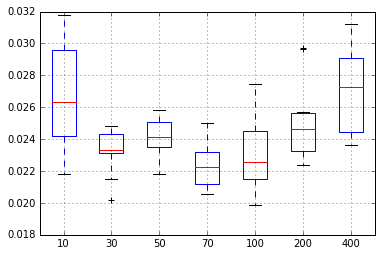

In [14]:
# realizar la evalaucion del desempeño de la red con cadas 7 configuraciones de celdas de memoria
# debido a la naturaleza estocastica de las red LSTM se repete el experimento 10 veces por cada grupo de celdas de memoria

features =data_train.shape[2]
time_steps =data_train.shape[1]

# definir el alcance de la búsqueda
params = [10, 30, 50, 70, 100, 200, 400]
n_repeats = 10

# valores de parámetros de búsqueda de cuadrícula
scores = DataFrame()

for value in params:
    # repite cada experimento varias veces
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
        print( '>%d/%d param=%f, loss=%f' % (i+1, n_repeats, value, loss))
    # almacenar resultados para este parámetro
    scores[str(value)] = loss_values

# estadísticas resumidas de resultados
print(scores.describe())

# grafica de cajas y bigotes de los resultados
scores.boxplot()
#pyplot.show()

Para hallar el numero de celdas de memoria de las capas LSTM se ejecuta el modelo 10 veces con 7 configuraciones definidas entre 10 y 400 celdas de memoria, con la grafica de cajas y bigotes se comparara el desempeño del modelo para cada una de las diferentes configuraciones, partiendo que se busca minimizar la perdida del modelo se observa que la estructura de la capa oculta LSTM con 70 celdas de memoria registra la menor perdida media con 2.23% y la configuracion con 50 celdas de memoria indica
la menor desviacion estandar con 0.14 %, considerando que, el objetivo es seleccionar una configuracion con un nivel de perdida bajo (mayor precision) y la menor varianza posible (mayor estabilidad), para este caso es viable seleccionar configuraciones entre 30, 50 y 70 celdas de memoria para la capa LSTM de la red neuronal profunda.

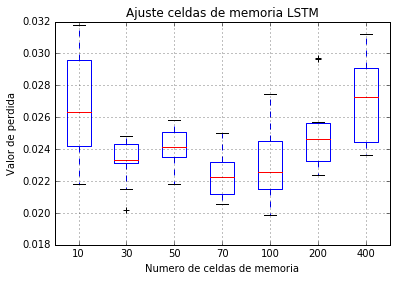

In [32]:
# exportar el grafico de cajas y bigotes
box=scores.boxplot()
plt.title("Ajuste celdas de memoria LSTM")
plt.xlabel("Numero de celdas de memoria")
plt.ylabel("Valor de perdida")
plt.savefig('box3.png')

              10         30         50         70        100        200  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.026839   0.023224   0.024062   0.022289   0.023207   0.025167   
std     0.003522   0.001449   0.001364   0.001445   0.002402   0.002624   
min     0.021807   0.020213   0.021784   0.020558   0.019874   0.022380   
25%     0.024172   0.023114   0.023526   0.021161   0.021531   0.023247   
50%     0.026351   0.023305   0.024117   0.022245   0.022585   0.024613   
75%     0.029585   0.024298   0.025053   0.023180   0.024523   0.025622   
max     0.031805   0.024850   0.025812   0.024990   0.027468   0.029704   

             400  
count  10.000000  
mean    0.027099  
std     0.002809  
min     0.023634  
25%     0.024445  
50%     0.027245  
75%     0.029111  
max     0.031193  


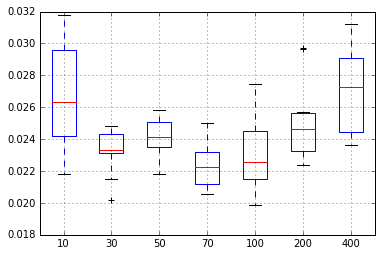

In [15]:
# estadistica descriptiva
print(scores.describe())
# box and whisker plot of results
scores.boxplot()
pyplot.show()

 ## Busqueda tamaño de lote (Batch size)

In [17]:
# entrenar modelo LSTM
def fit_model(n_batch):
   # definir modelo
    model = Sequential()
    model.add(LSTM(70, input_shape=(time_steps, features),kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='sigmoid'))
    # compilar modelo
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # entrenar modelo
    history = model.fit(data_train, label_train, epochs=20, batch_size=n_batch, shuffle=False, verbose=0)
    # evaluar modelo
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss


>1/3 param=16.000000, loss=0.022579
>2/3 param=16.000000, loss=0.020061
>3/3 param=16.000000, loss=0.022701
>1/3 param=32.000000, loss=0.022434
>2/3 param=32.000000, loss=0.023430
>3/3 param=32.000000, loss=0.024475
>1/3 param=64.000000, loss=0.024442
>2/3 param=64.000000, loss=0.025638
>3/3 param=64.000000, loss=0.025265
>1/3 param=128.000000, loss=0.026736
>2/3 param=128.000000, loss=0.021972
>3/3 param=128.000000, loss=0.024213
>1/3 param=256.000000, loss=0.024617
>2/3 param=256.000000, loss=0.025572
>3/3 param=256.000000, loss=0.027227
>1/3 param=512.000000, loss=0.029378
>2/3 param=512.000000, loss=0.032352
>3/3 param=512.000000, loss=0.024517
>1/3 param=1024.000000, loss=0.034317
>2/3 param=1024.000000, loss=0.031553
>3/3 param=1024.000000, loss=0.029367
             16        32        64       128       256       512      1024
count  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000
mean   0.021780  0.023446  0.025115  0.024307  0.025805  0.028749  0.031746
s

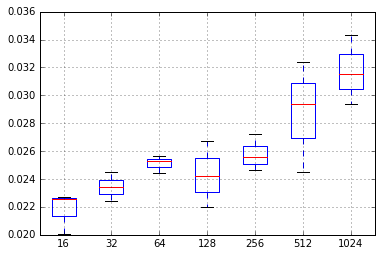

In [18]:

features =data_train.shape[2]
time_steps =data_train.shape[1]


params = [16, 32, 64, 128, 256, 512, 1024]
n_repeats = 3


scores = DataFrame()

for value in params:
    # repetir
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
        print( '>%d/%d param=%f, loss=%f' % (i+1, n_repeats, value, loss))
    # almacenar
    scores[str(value)] = loss_values

# estadisticas resumidas
print(scores.describe())

# graficar
scores.boxplot()
#pyplot.show()


Se presenta la grafica de cajas y bigotes con los resultados finales con el proposito de medir el desempeño y variacion del modelo, el tamaño de lote con valor de 16 da como resultado la menor perdida media con 2.18% y una desviacion estandar de 0.15%. Para encontrar un balance entre velocidad de
aprendizaje y menor perdida, se selecciona como tamaño de lote optimo para el modelo
el valor de 32 con una perdida media de 2.34% y una desviacion estandar de 0.1%.

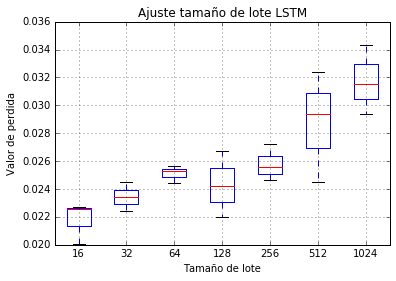

In [19]:
# exportar grafico
box8=scores.boxplot()
plt.title("Ajuste tamaño de lote LSTM")
plt.xlabel("Tamaño de lote")
plt.ylabel("Valor de perdida")
plt.savefig('box8.png')

In [12]:
# probar tamaño de lote 8 y 16 para compararlo

def fit_model(n_batch):
   
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_steps, features),kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='sigmoid' ))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    history = model.fit(data_train, label_train, epochs=20, batch_size=n_batch, shuffle=False, verbose=1)
    
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
20531/20531 [==============================] - 142s 7ms/step - loss: 0.2310
Epoch 2/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1561
Epoch 3/20
20531/20531 [==============================] - 132s 6ms/step - loss: 0.1351
Epoch 4/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1235
Epoch 5/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1194
Epoch 6/20
20531/20531 [==============================] - 133s 7ms/step - loss: 0.1144
Epoch 7/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1080
Epoch 8/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1083
Epoch 9/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.1184
Epoch 10/20
20531/20531 [==============================] - 133s 6ms/step - loss: 0.0993
Epoch 11/20
20531/20531 [====

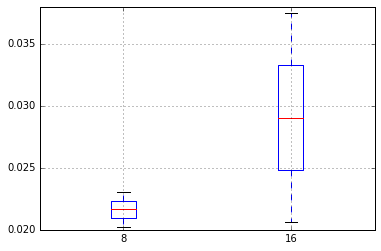

In [13]:
from matplotlib import pyplot

features =data_train.shape[2]
time_steps =data_train.shape[1]


params = [8, 16]
n_repeats = 2


scores = DataFrame()

for value in params:
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
        print( '>%d/%d param=%f, loss=%f' % (i+1, n_repeats, value, loss))
    # almacenar
    scores[str(value)] = loss_values


print(scores.describe())


scores.boxplot()
pyplot.show()

El tamaño de lote en 8 aumenta significativamente el tiempo de entrenamiento de la red por lo que se descarta para este analisis, un tamaño de lote entre 32 y 128 mejora la velocidad de entrenamiento con un nivel de perdida aceptable.

## Regularizacion - Busqueda % de abandono - Dropout


In [22]:
# busqueda capa de abandono % de dropout

def fit_model(n_dropout):
   # definir modelo
    model = Sequential()
    model.add(LSTM(70, input_shape=(time_steps, features),kernel_initializer='glorot_normal'))
    model.add(Dropout(n_dropout))
    model.add(Dense(1, activation='sigmoid'))
    # compilar modelo
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # entrenar modelo
    history = model.fit(data_train, label_train, epochs=20, batch_size=32, shuffle=False, verbose=0)
    # evaluar modelo
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss


In [23]:
features =data_train.shape[2]
time_steps =data_train.shape[1]

# % de abandono
params = [0.1, 0.2, 0.4, 0.6]
n_repeats = 3

scores = DataFrame()

for value in params:
    # repetir
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
        print( '>%d/%d param=%f, loss=%f' % (i+1, n_repeats, value, loss))
    # almacenar resultados
    scores[str(value)] = loss_values



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
>1/3 param=0.100000, loss=0.024248
>2/3 param=0.100000, loss=0.022994
>3/3 param=0.100000, loss=0.023284
>1/3 param=0.200000, loss=0.033632
>2/3 param=0.200000, loss=0.022064
>3/3 param=0.200000, loss=0.024520
>1/3 param=0.400000, loss=0.022586
>2/3 param=0.400000, loss=0.024508
>3/3 param=0.400000, loss=0.021796
>1/3 param=0.600000, loss=0.023393
>2/3 param=0.600000, loss=0.023645
>3/3 param=0.600000, loss=0.025695


            0.1       0.2       0.4       0.6
count  3.000000  3.000000  3.000000  3.000000
mean   0.023509  0.026739  0.022963  0.024245
std    0.000657  0.006095  0.001395  0.001263
min    0.022994  0.022064  0.021796  0.023393
25%    0.023139  0.023292  0.022191  0.023519
50%    0.023284  0.024520  0.022586  0.023645
75%    0.023766  0.029076  0.023547  0.024670
max    0.024248  0.033632  0.024508  0.025695


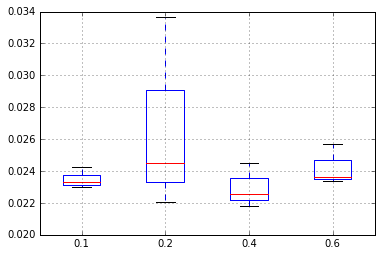

In [24]:
# estadistica descriptiva resumida 
print(scores.describe())

# grafica de cajas y bigotes
scores.boxplot()
pyplot.show()

En la grafica de cajas y bigotes se observa que al incluir una capa de regularizacion donde se evaluan diferentes porcentajes de abandono, en este caso la capa con Dropout de valor 40% da como resultado la menor perdida media con 2.30% y una desviacion estandar de 0.14%.

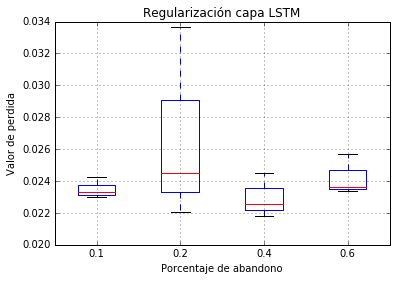

In [25]:
# exportar grafica
box9=scores.boxplot()
plt.title("Regularización capa LSTM")
plt.xlabel("Porcentaje de abandono")
plt.ylabel("Valor de perdida")
plt.savefig('box9.png')

## Ajuste de pesos por clase 

In [17]:
# Ajuste de pesos por desequilibrio de clases en la base de entrenamiento
def fit_model(weights):
   # definir modelo
    model = Sequential()
    model.add(LSTM(70, input_shape=(time_steps, features),kernel_initializer='glorot_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compilar modelo
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # entrenar modelo
    history = model.fit(data_train, label_train, epochs=20, batch_size=32, shuffle=False, verbose=2, class_weight=weights)
    # evaluar modelo
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss

In [18]:

features =data_train.shape[2]
time_steps =data_train.shape[1]

# definir 3 posibles configuraciones de pesos de clase
params = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
n_repeats = 3


scores = DataFrame()

for value in params:
    # repetir experimiento
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
    # almacenar resultados
    scores[str(value)] = loss_values

Epoch 1/20
 - 43s - loss: 0.2684
Epoch 2/20
 - 42s - loss: 0.1713
Epoch 3/20
 - 42s - loss: 0.1422
Epoch 4/20
 - 42s - loss: 0.1274
Epoch 5/20
 - 42s - loss: 0.1272
Epoch 6/20
 - 42s - loss: 0.1086
Epoch 7/20
 - 42s - loss: 0.1017
Epoch 8/20
 - 42s - loss: 0.0958
Epoch 9/20
 - 42s - loss: 0.0904
Epoch 10/20
 - 42s - loss: 0.0867
Epoch 11/20
 - 42s - loss: 0.0825
Epoch 12/20
 - 42s - loss: 0.0780
Epoch 13/20
 - 42s - loss: 0.0747
Epoch 14/20
 - 42s - loss: 0.0737
Epoch 15/20
 - 42s - loss: 0.0723
Epoch 16/20
 - 42s - loss: 0.0708
Epoch 17/20
 - 42s - loss: 0.0729
Epoch 18/20
 - 42s - loss: 0.0622
Epoch 19/20
 - 42s - loss: 0.0636
Epoch 20/20
 - 42s - loss: 0.0610
Epoch 1/20
 - 43s - loss: 0.2377
Epoch 2/20
 - 42s - loss: 0.1452
Epoch 3/20
 - 41s - loss: 0.1266
Epoch 4/20
 - 42s - loss: 0.1225
Epoch 5/20
 - 42s - loss: 0.1167
Epoch 6/20
 - 42s - loss: 0.1148
Epoch 7/20
 - 41s - loss: 0.1090
Epoch 8/20
 - 41s - loss: 0.1168
Epoch 9/20
 - 41s - loss: 0.1010
Epoch 10/20
 - 41s - loss: 0.100

       {0: 1, 1: 1}  {0: 1, 1: 10}  {0: 1, 1: 100}
count      3.000000       3.000000        3.000000
mean       0.023628       0.062752        0.301658
std        0.002278       0.004072        0.065390
min        0.020997       0.058750        0.226763
25%        0.022960       0.060683        0.278784
50%        0.024923       0.062616        0.330805
75%        0.024943       0.064753        0.339106
max        0.024963       0.066891        0.347407


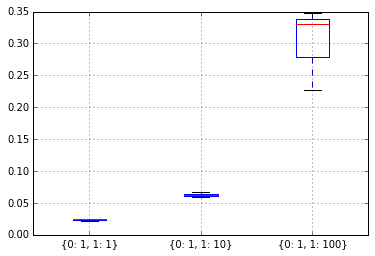

In [19]:
# resultados estadistica descriptiva y grafico
print(scores.describe())

scores.boxplot()
pyplot.show()

Se presenta la grafica de cajas y bigotes con las diferentes ponderaciones de clase, que se asignan para penalizar los errores de clasificacion de la clase minoritaria, cuando se establece un peso de 100 a la
clase 1 el error de precision aumenta, ya que se genera un aumento de los falsos positivos, por lo tanto, el rango de valor de configuracion de peso para la clase minoritaria puede oscilar entre 1 y 10 para una precision equilibrada entre las dos clases del modelo.

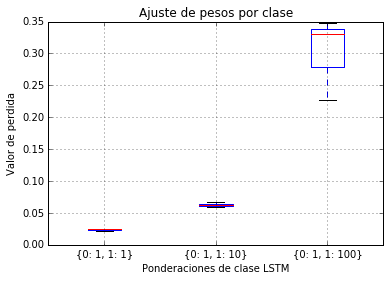

In [20]:
# expotar grafica
box11=scores.boxplot()
plt.title("Ajuste de pesos por clase")
plt.xlabel("Ponderaciones de clase LSTM")
plt.ylabel("Valor de perdida")
plt.savefig('box11.png')